## 导入必要的包以及数据的读取

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

d:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 读取数据并查看
data = pd.read_csv("data/train.csv")
 
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## 数据清洗

In [4]:
# 查看数据行列
data.shape

(891, 12)

In [5]:
# 检查NA值的情况
data.isnull().sum()##统计每列的缺失值

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

可以看到Age, Cabin, Embarked这三列均存在缺失值，其中Cabin列缺失很严重。不过这列表示船舱号，直观上我们觉得这个跟最终是否能幸存关系不大，所以缺失就缺失吧，可以不管啦

泰坦尼克号这个数据集中，有乘客ID、是否存活、船票等级、乘客姓名、乘客性别、年龄、船上兄弟姊妹或配偶个数、床上父母或子女个数、船票号码、船票价格、船舱号、上船港口等数据。

显然，是否存活是我们将要预测的量，而乘客ID、乘客姓名、船票号码、船舱号，我们觉得跟最终是否能存活关系不大，于是忽略它们，剩余其他的列作为后续模型训练的特征。

选取特征并查看选取后的数据：

In [3]:
# 选取数据集中有用的特征
data = data.drop(labels=['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)#删除多列
data.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S

In [4]:
# 去除有缺失值的行
data = data.dropna()##把有缺失的行删掉就OK了

上边留下来的列，Pclass表示船票等级，为有序分类变量，已经是数值型；Sex和Embarked为无序分类变量，为字符型；Age、SibSp、Parch、Fare为连续变量。

sklearn中模型最后训练的数据需要是数值型的，因此Sex和Embarked这两列的数值需要转换为数值型。

我们直接用pandas中的get_dummies即可对无序分类变量进行编码：

In [5]:
# 分类变量编码
data_dummy = pd.get_dummies(data[['Sex', 'Embarked']])##独热编码，和sklearn OneHot一样

编码后与原来其他列的数据重新拼接起来：

编码后和原来其他列数据拼接

In [6]:
data_conti = pd.DataFrame(data, columns=['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], index=data.index)
data = data_conti.join(data_dummy)#拼接的意思

In [7]:
X = data.iloc[:, 1:]##取出特征列
y = data.iloc[:, 0]##取出的就是标签列
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)##数据集的划分

要保证模型训练时快速收敛，我们需要对数据集中连续的数据列进行缩放，这里使用标准化的方法：

In [8]:
# 标准化
stdsc = StandardScaler()#实例化
X_train_conti_std = stdsc.fit_transform(X_train[['Age', 'SibSp', 'Parch', 'Fare']])#拟合
X_test_conti_std = stdsc.fit_transform(X_test[['Age', 'SibSp', 'Parch', 'Fare']])#拟合
# 将ndarray转为dataframe
X_train_conti_std = pd.DataFrame(data=X_train_conti_std, columns=['Age', 'SibSp', 'Parch', 'Fare'], index=X_train.index)
X_test_conti_std = pd.DataFrame(data=X_test_conti_std, columns=['Age', 'SibSp', 'Parch', 'Fare'], index=X_test.index)

In [13]:
#基于训练集使用逻辑回归建模
classifier = LogisticRegression(random_state=0)#实例化算法
classifier.fit(X_train, y_train)#模型训练
 
# 将模型应用于测试集并查看混淆矩阵
y_pred = classifier.predict(X_test)#预测
confusion_matrix = confusion_matrix(y_test, y_pred)#打印混淆矩阵，是很多评分函数的标准来源
print(confusion_matrix)#打印混淆矩阵

[[105  20]
 [ 28  61]]


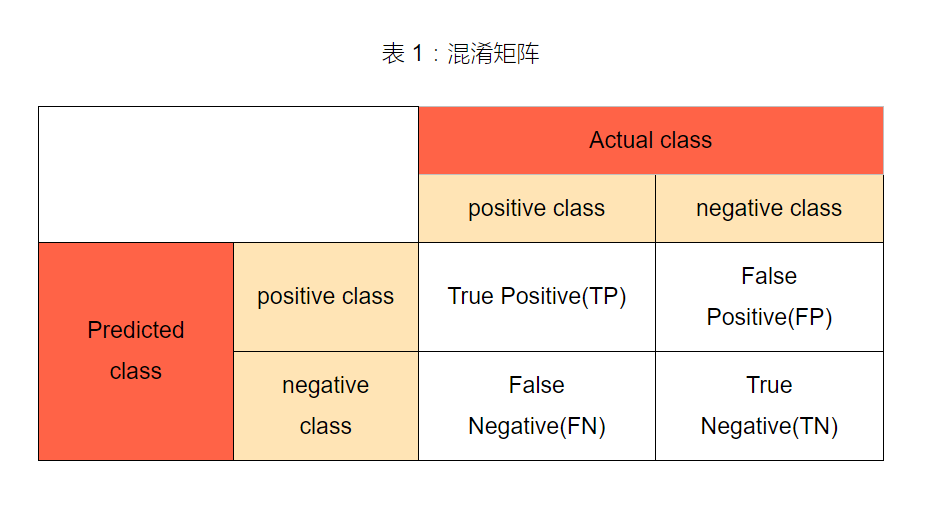

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html #关于混淆矩阵的sklearn的官方文档

https://www.cnblogs.com/wuliytTaotao/p/9285227.html #详细说明
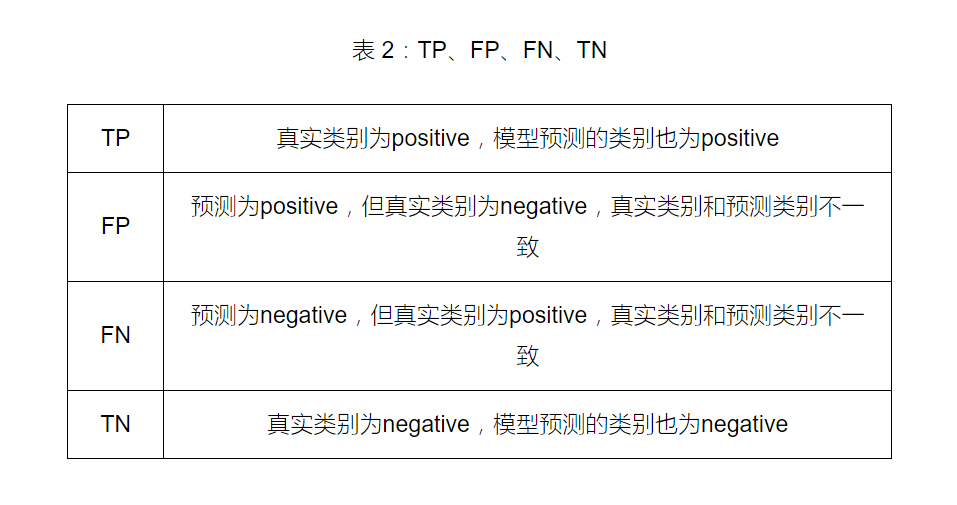

In [14]:
#在测试集上的准确率
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.78


In [ ]:
##对测试集做同样的数据处理工作，然后再去预测值，做好提交